# Analyst Assist: OSINT Text Triage & Risk Scoring (NLP)

This notebook demonstrates a lightweight, end-to-end NLP pipeline for triaging unstructured open-source text into mission-relevant categories, generating interpretable risk scores, and producing analyst-ready summaries.

**Core capabilities demonstrated:**
- Text cleaning and normalization  
- NLP-based classification using TF-IDF + linear models  
- Interpretable risk scoring  
- Keyword and entity extraction  
- Analyst-facing decision support outputs


## 1. Environment Setup & Imports

We begin by importing standard Python libraries for data manipulation, machine learning, and visualization.  
The goal is to keep the stack lightweight and reproducible using well-established NLP tooling.


In [16]:
import re
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt


## 2. Dataset Ingestion & Category Mapping

We load a subset of the 20 Newsgroups dataset and map raw discussion topics into higher-level, mission-relevant categories (e.g., Cyber, Fraud, Physical Threat).

This simulates how open-source or customer text would be normalized into analyst-usable labels.


In [17]:
CATEGORIES_RAW = [
    "sci.crypt",              # Cyber
    "talk.politics.misc",     # Compliance-ish (proxy)
    "talk.politics.guns",     # Physical threat proxy
    "soc.religion.christian", # Harassment/other proxy
    "rec.autos",              # Fraud/other proxy
    "misc.forsale",           # Fraud/other proxy
]

raw = fetch_20newsgroups(subset="all", categories=CATEGORIES_RAW, remove=("headers", "footers", "quotes"))

# Map raw newsgroups to your demo labels
MAP_TO_LABEL = {
    "sci.crypt": "Cyber",
    "talk.politics.misc": "Sanctions/Compliance",
    "talk.politics.guns": "Physical Threat",
    "soc.religion.christian": "Harassment",
    "rec.autos": "Other",
    "misc.forsale": "Fraud",
}

labels = [MAP_TO_LABEL[raw.target_names[t]] for t in raw.target]

df = pd.DataFrame({"text": raw.data, "label": labels})
df = df[df["text"].str.len() > 50].reset_index(drop=True)  # basic cleanup
df["label"].value_counts()


label
Harassment              969
Cyber                   944
Fraud                   936
Other                   910
Physical Threat         872
Sanctions/Compliance    741
Name: count, dtype: int64

## 3. Text Cleaning & Normalization

Raw text is cleaned and normalized to reduce noise while preserving meaningful signal.  
This step standardizes casing, removes URLs and special characters, and prepares the data for vectorization.


In [18]:
def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"[^a-z0-9\s\-\']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["clean"] = df["text"].astype(str).map(clean_text)
df[["label", "clean"]].head()


,label,clean
0,Other,last night i had a dream that my dad bought a ...
1,Other,the girl's ok actually and she recovered well ...
2,Harassment,mary at that time appeared to a girl named ber...
3,Harassment,fred gilham asks may 11 whether it is true tha...
4,Fraud,i have the following program on cd rom forsale...


## 4. Train / Test Split

The dataset is split into training and testing sets using stratified sampling to preserve class balance.  
This allows us to evaluate model performance on unseen data.


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    df["clean"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

len(X_train), len(X_test), pd.Series(y_train).value_counts()


(4297,
 1075,
 label
 Harassment              775
 Cyber                   755
 Fraud                   749
 Other                   728
 Physical Threat         697
 Sanctions/Compliance    593
 Name: count, dtype: int64)

## 5. Text Vectorization & Classification Model

We convert cleaned text into numerical features using TF-IDF (unigrams + bigrams), then train a logistic regression classifier.

This model is chosen for its speed, strong baseline performance, and interpretability.


In [20]:
clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=3,
        max_df=0.9,
        stop_words="english"
    )),
    ("model", LogisticRegression(max_iter=2000, n_jobs=None))
])

clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print(classification_report(y_test, pred))


                      precision    recall  f1-score   support

               Cyber       0.91      0.87      0.89       189
               Fraud       0.92      0.92      0.92       187
          Harassment       0.93      0.95      0.94       194
               Other       0.87      0.92      0.90       182
     Physical Threat       0.80      0.82      0.81       175
Sanctions/Compliance       0.79      0.73      0.76       148

            accuracy                           0.88      1075
           macro avg       0.87      0.87      0.87      1075
        weighted avg       0.87      0.88      0.87      1075



## 6. Model Evaluation

We evaluate classification performance using precision, recall, and F1-score, along with a confusion matrix to understand class-level behavior.


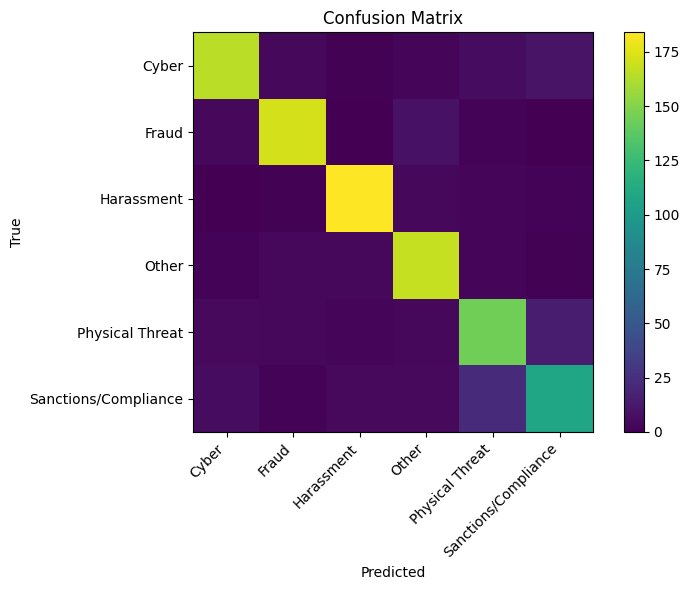

In [21]:
labels_sorted = sorted(df["label"].unique())
cm = confusion_matrix(y_test, pred, labels=labels_sorted)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest")
plt.xticks(range(len(labels_sorted)), labels_sorted, rotation=45, ha="right")
plt.yticks(range(len(labels_sorted)), labels_sorted)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.show()


## 7. Model Interpretability: Key Terms per Class

To support analyst trust and transparency, we extract the highest-weighted terms associated with each predicted category.

This helps explain *why* the model makes certain predictions.


In [22]:
vectorizer = clf.named_steps["tfidf"]
model = clf.named_steps["model"]

feature_names = np.array(vectorizer.get_feature_names_out())
classes = model.classes_

top_k = 12
rows = []
for i, cls in enumerate(classes):
    coefs = model.coef_[i]
    top_pos_idx = np.argsort(coefs)[-top_k:][::-1]
    rows.append((cls, ", ".join(feature_names[top_pos_idx])))

pd.DataFrame(rows, columns=["class", "top_terms"])


,class,top_terms
0,Cyber,"clipper, key, encryption, nsa, chip, governmen..."
1,Fraud,"sale, offer, shipping, condition, sell, 00, as..."
2,Harassment,"god, church, christian, jesus, bible, christia..."
3,Other,"car, cars, engine, ford, oil, dealer, honda, s..."
4,Physical Threat,"gun, guns, fbi, weapons, bd, nra, firearms, at..."
5,Sanctions/Compliance,"people, clayton, gay, health, tax, drugs, men,..."


## 8. Risk Scoring

Predicted class probabilities are combined with category-specific severity weights to generate a normalized risk score (0–100).

This mirrors real-world prioritization workflows used in analyst triage systems.


In [23]:
SEVERITY = {
    "Physical Threat": 1.00,
    "Cyber": 0.85,
    "Sanctions/Compliance": 0.75,
    "Fraud": 0.70,
    "Harassment": 0.55,
    "Other": 0.30
}

proba = clf.predict_proba(X_test)
pred_labels = clf.predict(X_test)

# risk score = max prob * severity(label) * 100
max_proba = proba.max(axis=1)
severity = np.array([SEVERITY[l] for l in pred_labels])
risk_score = (max_proba * severity * 100).round(1)

out = pd.DataFrame({
    "text": df.loc[X_test.index, "text"].values,
    "clean": X_test.values,
    "predicted_category": pred_labels,
    "confidence": max_proba.round(3),
    "risk_score": risk_score
})

out.sort_values("risk_score", ascending=False).head(10)


,text,clean,predicted_category,confidence,risk_score
897,": > Last year the US suffered almost 10,000 wr...",last year the us suffered almost 10 000 wrongf...,Physical Threat,0.930,93.0
835,"April 19, 1993\n \nAs William O. Douglas noted...",april 19 1993 as william o douglas noted if a ...,Physical Threat,0.901,90.1
275,From article <1993Apr18.001319.2340@gnv.ifas.u...,from article 1993apr18 001319 2340 gnv ifas uf...,Physical Threat,0.901,90.1
403,"\nFrom: ""Preston K. Covey"" <covey+@andrew.cmu....",from preston k covey covey andrew cmu edu subj...,Physical Threat,0.890,89.0
940,\n\nBut this is all gun control laws end up do...,but this is all gun control laws end up doing ...,Physical Threat,0.878,87.8
117,\n\nWhy don't you call the City and ask? Oak P...,why don't you call the city and ask oak park a...,Physical Threat,0.873,87.3
769,"\n\n\nKilled by handgun, or killed? If I'm de...",killed by handgun or killed if i'm dead i don'...,Physical Threat,0.872,87.2
959,This was posted by Lyn Bates to the firearms-p...,this was posted by lyn bates to the firearms-p...,Physical Threat,0.854,85.4
163,"[An article from comp.org.eff.news, EFFector O...",an article from comp org eff news effector onl...,Cyber,0.997,84.8
807,Note: This file will also be available via an...,note this file will also be available via anon...,Cyber,0.996,84.7


## 9. Analyst-Ready Summaries & Keyword Extraction

For each document, we extract the most influential keywords and generate a short, human-readable analyst summary describing the detected signal.


In [24]:
def top_keywords_for_doc(text, vectorizer, top_n=8):
    vec = vectorizer.transform([text])
    if vec.nnz == 0:
        return []
    idx = np.argsort(vec.data)[-top_n:][::-1]
    feature_idx = vec.indices[idx]
    return feature_names[feature_idx].tolist()

def analyst_summary(row):
    kws = top_keywords_for_doc(row["clean"], vectorizer, top_n=6)
    return f"{row['predicted_category']} signal detected. Key terms: {', '.join(kws[:6])}."

out["top_keywords"] = out["clean"].apply(lambda s: top_keywords_for_doc(s, vectorizer, top_n=8))
out["analyst_summary"] = out.apply(analyst_summary, axis=1)

out[["predicted_category", "risk_score", "confidence", "top_keywords", "analyst_summary"]].head(8)


,predicted_category,risk_score,confidence,top_keywords,analyst_summary
0,Sanctions/Compliance,29.8,0.398,"[taxation, taxes, town having, dale cook, cook...",Sanctions/Compliance signal detected. Key term...
1,Cyber,40.9,0.482,"[care, nsa, say nsa, redeeming, elimination, l...","Cyber signal detected. Key terms: care, nsa, s..."
2,Physical Threat,48.4,0.484,"[roads, public, parks, segments, does work, dr...",Physical Threat signal detected. Key terms: ro...
3,Physical Threat,40.8,0.408,"[disaster, watch, shouting, seizure, watergate...",Physical Threat signal detected. Key terms: di...
4,Harassment,30.0,0.545,"[technology, non christian, evangelical, non, ...",Harassment signal detected. Key terms: technol...
5,Physical Threat,34.7,0.347,"[db, hard believe, accidental, horrible, refus...",Physical Threat signal detected. Key terms: db...
6,Physical Threat,45.9,0.459,"[rec guns, consulted, rec, firearm, purchased,...",Physical Threat signal detected. Key terms: re...
7,Physical Threat,38.5,0.385,"[tactics, intended, using tear, peacefull, sec...",Physical Threat signal detected. Key terms: ta...


## 10. Named Entity Extraction (Optional Enhancement)

We apply named entity recognition to extract people, organizations, locations, and dates from text, enriching analyst context without manual review.


In [25]:
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_entities(text, max_ents=8):
    doc = nlp(text[:2000])  # cap length for speed
    ents = []
    for ent in doc.ents:
        if ent.label_ in {"PERSON", "ORG", "GPE", "LOC", "DATE"}:
            ents.append(f"{ent.text} ({ent.label_})")
    # de-dup while preserving order
    seen = set()
    uniq = []
    for e in ents:
        if e not in seen:
            uniq.append(e)
            seen.add(e)
    return uniq[:max_ents]

out["key_entities"] = out["text"].apply(extract_entities)
out[["predicted_category", "risk_score", "key_entities", "analyst_summary"]].head(10)


,predicted_category,risk_score,key_entities,analyst_summary
0,Sanctions/Compliance,29.8,"[US (GPE), Dale Cook (PERSON), Abbey (PERSON)]",Sanctions/Compliance signal detected. Key term...
1,Cyber,40.9,[NSA (ORG)],"Cyber signal detected. Key terms: care, nsa, s..."
2,Physical Threat,48.4,[Jim (PERSON)],Physical Threat signal detected. Key terms: ro...
3,Physical Threat,40.8,"[Cambodia (GPE), My Lai (PERSON), VietNam (GPE...",Physical Threat signal detected. Key terms: di...
4,Harassment,30.0,"[Jacques Ellul (PERSON), Alvin Toffler (PERSON...",Harassment signal detected. Key terms: technol...
5,Physical Threat,34.7,[James (PERSON)],Physical Threat signal detected. Key terms: db...
6,Physical Threat,45.9,"[the summer of 1991 (DATE), early March of thi...",Physical Threat signal detected. Key terms: re...
7,Physical Threat,38.5,"[King (PERSON), Waco (GPE), Clinton (PERSON)]",Physical Threat signal detected. Key terms: ta...
8,Harassment,42.3,"[Enoch and Elijah (ORG), Mary (PERSON), St. Ge...","Harassment signal detected. Key terms: belief,..."
9,Harassment,53.8,"[Jesus (PERSON), earth (LOC), NEVER (ORG), 200...","Harassment signal detected. Key terms: jesus, ..."


## 11. Final Analyst View

All outputs are combined into a single analyst-ready table containing:
- Text excerpt  
- Predicted category  
- Risk score  
- Confidence level  
- Key terms  
- Extracted entities  
- Auto-generated summary  

This represents the final decision-support artifact produced by the pipeline.


In [26]:
analyst_view = out.copy()
analyst_view["text"] = analyst_view["text"].str.replace(r"\s+", " ", regex=True).str.slice(0, 260) + "…"

analyst_view = analyst_view[[
    "text",
    "predicted_category",
    "risk_score",
    "confidence",
    "top_keywords",
    "key_entities",
    "analyst_summary"
]].sort_values("risk_score", ascending=False)

analyst_view.head(15)


,text,predicted_category,risk_score,confidence,top_keywords,key_entities,analyst_summary
897,": > Last year the US suffered almost 10,000 wr...",Physical Threat,93.0,0.930,"[seattle, vancouver, homicides, homicide, atta...","[Last year (DATE), US (GPE), FBI (ORG), the sa...",Physical Threat signal detected. Key terms: se...
835,"April 19, 1993 As William O. Douglas noted, ""I...",Physical Threat,90.1,0.901,"[hb, committee, sb, firearms, defeated, passed...","[April 19, 1993\n \n (DATE), William O. Dougla...",Physical Threat signal detected. Key terms: hb...
275,From article <1993Apr18.001319.2340@gnv.ifas.u...,Physical Threat,90.1,0.901,"[bear arms, guns, bear, arms, gnv ifas, ifas u...","[every year (DATE), Klintonistas (ORG), Statis...",Physical Threat signal detected. Key terms: be...
403,"From: ""Preston K. Covey"" <covey+@andrew.cmu.e...",Physical Threat,89.0,0.890,"[nejm, risk, gun, deaths, stat, risks, study, ...","[Preston K. Covey (PERSON), February 4th (DATE...",Physical Threat signal detected. Key terms: ne...
940,But this is all gun control laws end up doing...,Physical Threat,87.8,0.878,"[gun, laws, crimes, violent, gun control, viol...","[Karen McNutt (PERSON), Massachusetts (GPE), t...",Physical Threat signal detected. Key terms: gu...
117,Why don't you call the City and ask? Oak Park...,Physical Threat,87.3,0.873,"[oak, park, anti, anti gun, handgun, police, g...","[FFL (ORG), Oak Park (GPE), Village (PERSON), ...",Physical Threat signal detected. Key terms: oa...
769,"Killed by handgun, or killed? If I'm dead, I ...",Physical Threat,87.2,0.872,"[killed, murders, committing, handgun, intent,...","[England (GPE), Switzerland (GPE)]",Physical Threat signal detected. Key terms: ki...
959,This was posted by Lyn Bates to the firearms-p...,Physical Threat,85.4,0.854,"[batf, warrant, agents, media, police, koresh,...","[Lyn Bates (PERSON), Don Kates (PERSON), Bosto...",Physical Threat signal detected. Key terms: ba...
163,"[An article from comp.org.eff.news, EFFector O...",Cyber,84.8,0.997,"[administration, inquiry, agents, escrow agent...","[comp.org.eff.news (ORG), April 16, 1993 (DATE...",Cyber signal detected. Key terms: administrati...
807,Note: This file will also be available via ano...,Cyber,84.7,0.996,"[encryption, technology, chip, protect, key es...","[the NIST Computer Security (ORG), THE WHITE H...","Cyber signal detected. Key terms: encryption, ..."
